In [1]:
from keras_vggface.utils import preprocess_input
from project.dg_face import utils, detection, alignment, recognition
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn import svm
from sklearn.preprocessing import Normalizer, LabelEncoder

C:\Users\danil\Desktop\neuro\venv\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\danil\Desktop\neuro\venv\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\danil\Desktop\neuro\venv\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
model = recognition.make_cnn_model()
def get_embeddings(base_path):
    X, y = [], []
    images = []
    for person in os.listdir(base_path):
        for person_img in os.listdir(base_path + "/" + person):
            path = base_path + '/' + person + '/' + person_img
            print(path)
            img = utils.load_image(path)
            images.append(img)
            faces = detection.detect_faces(img)
            if len(faces) != 1:
                print(path, 'was skipped because of len(faces)=', len(faces))
                continue
            face_image = alignment.aligned_face(img, faces[0])
            face_image = preprocess_input(face_image.astype(float), version=1)
            encoding = model.predict(np.array([face_image]))[0]
            X.append(encoding)
            y.append(person)
    return X, y, images

In [3]:
X_train_raw, y_train_raw, train_images = get_embeddings("images_30_20/train")
X_test_raw, y_test_raw, test_images = get_embeddings("images_30_20/test")
print(len(X_train_raw), len(X_test_raw))

images_30_20/train/worker0/001257.jpg
1/1 [==============================] - 0s 351ms/step
images_30_20/train/worker0/008392.jpg
1/1 [==============================] - 0s 140ms/step
images_30_20/train/worker0/013825.jpg
1/1 [==============================] - 0s 144ms/step
images_30_20/train/worker1/185949.jpg
1/1 [==============================] - 0s 135ms/step
images_30_20/train/worker1/187455.jpg
1/1 [==============================] - 0s 146ms/step
images_30_20/train/worker1/194128.jpg
1/1 [==============================] - 0s 151ms/step
images_30_20/train/worker10/165300.jpg
1/1 [==============================] - 0s 146ms/step
images_30_20/train/worker10/168172.jpg
1/1 [==============================] - 0s 144ms/step
images_30_20/train/worker10/173174.jpg
1/1 [==============================] - 0s 137ms/step
images_30_20/train/worker11/186581.jpg
1/1 [==============================] - 0s 287ms/step
images_30_20/train/worker11/191573.jpg
1/1 [==============================] - 0s 308ms

In [4]:
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train_raw)
X_test = in_encoder.transform(X_test_raw)
out_encoder = LabelEncoder()
y_train = out_encoder.fit_transform(y_train_raw)

In [5]:
clf = svm.SVC(kernel='rbf', probability=True, C=50, random_state=10)
clf.fit(X_train, y_train)

SVC(C=50, probability=True, random_state=10)

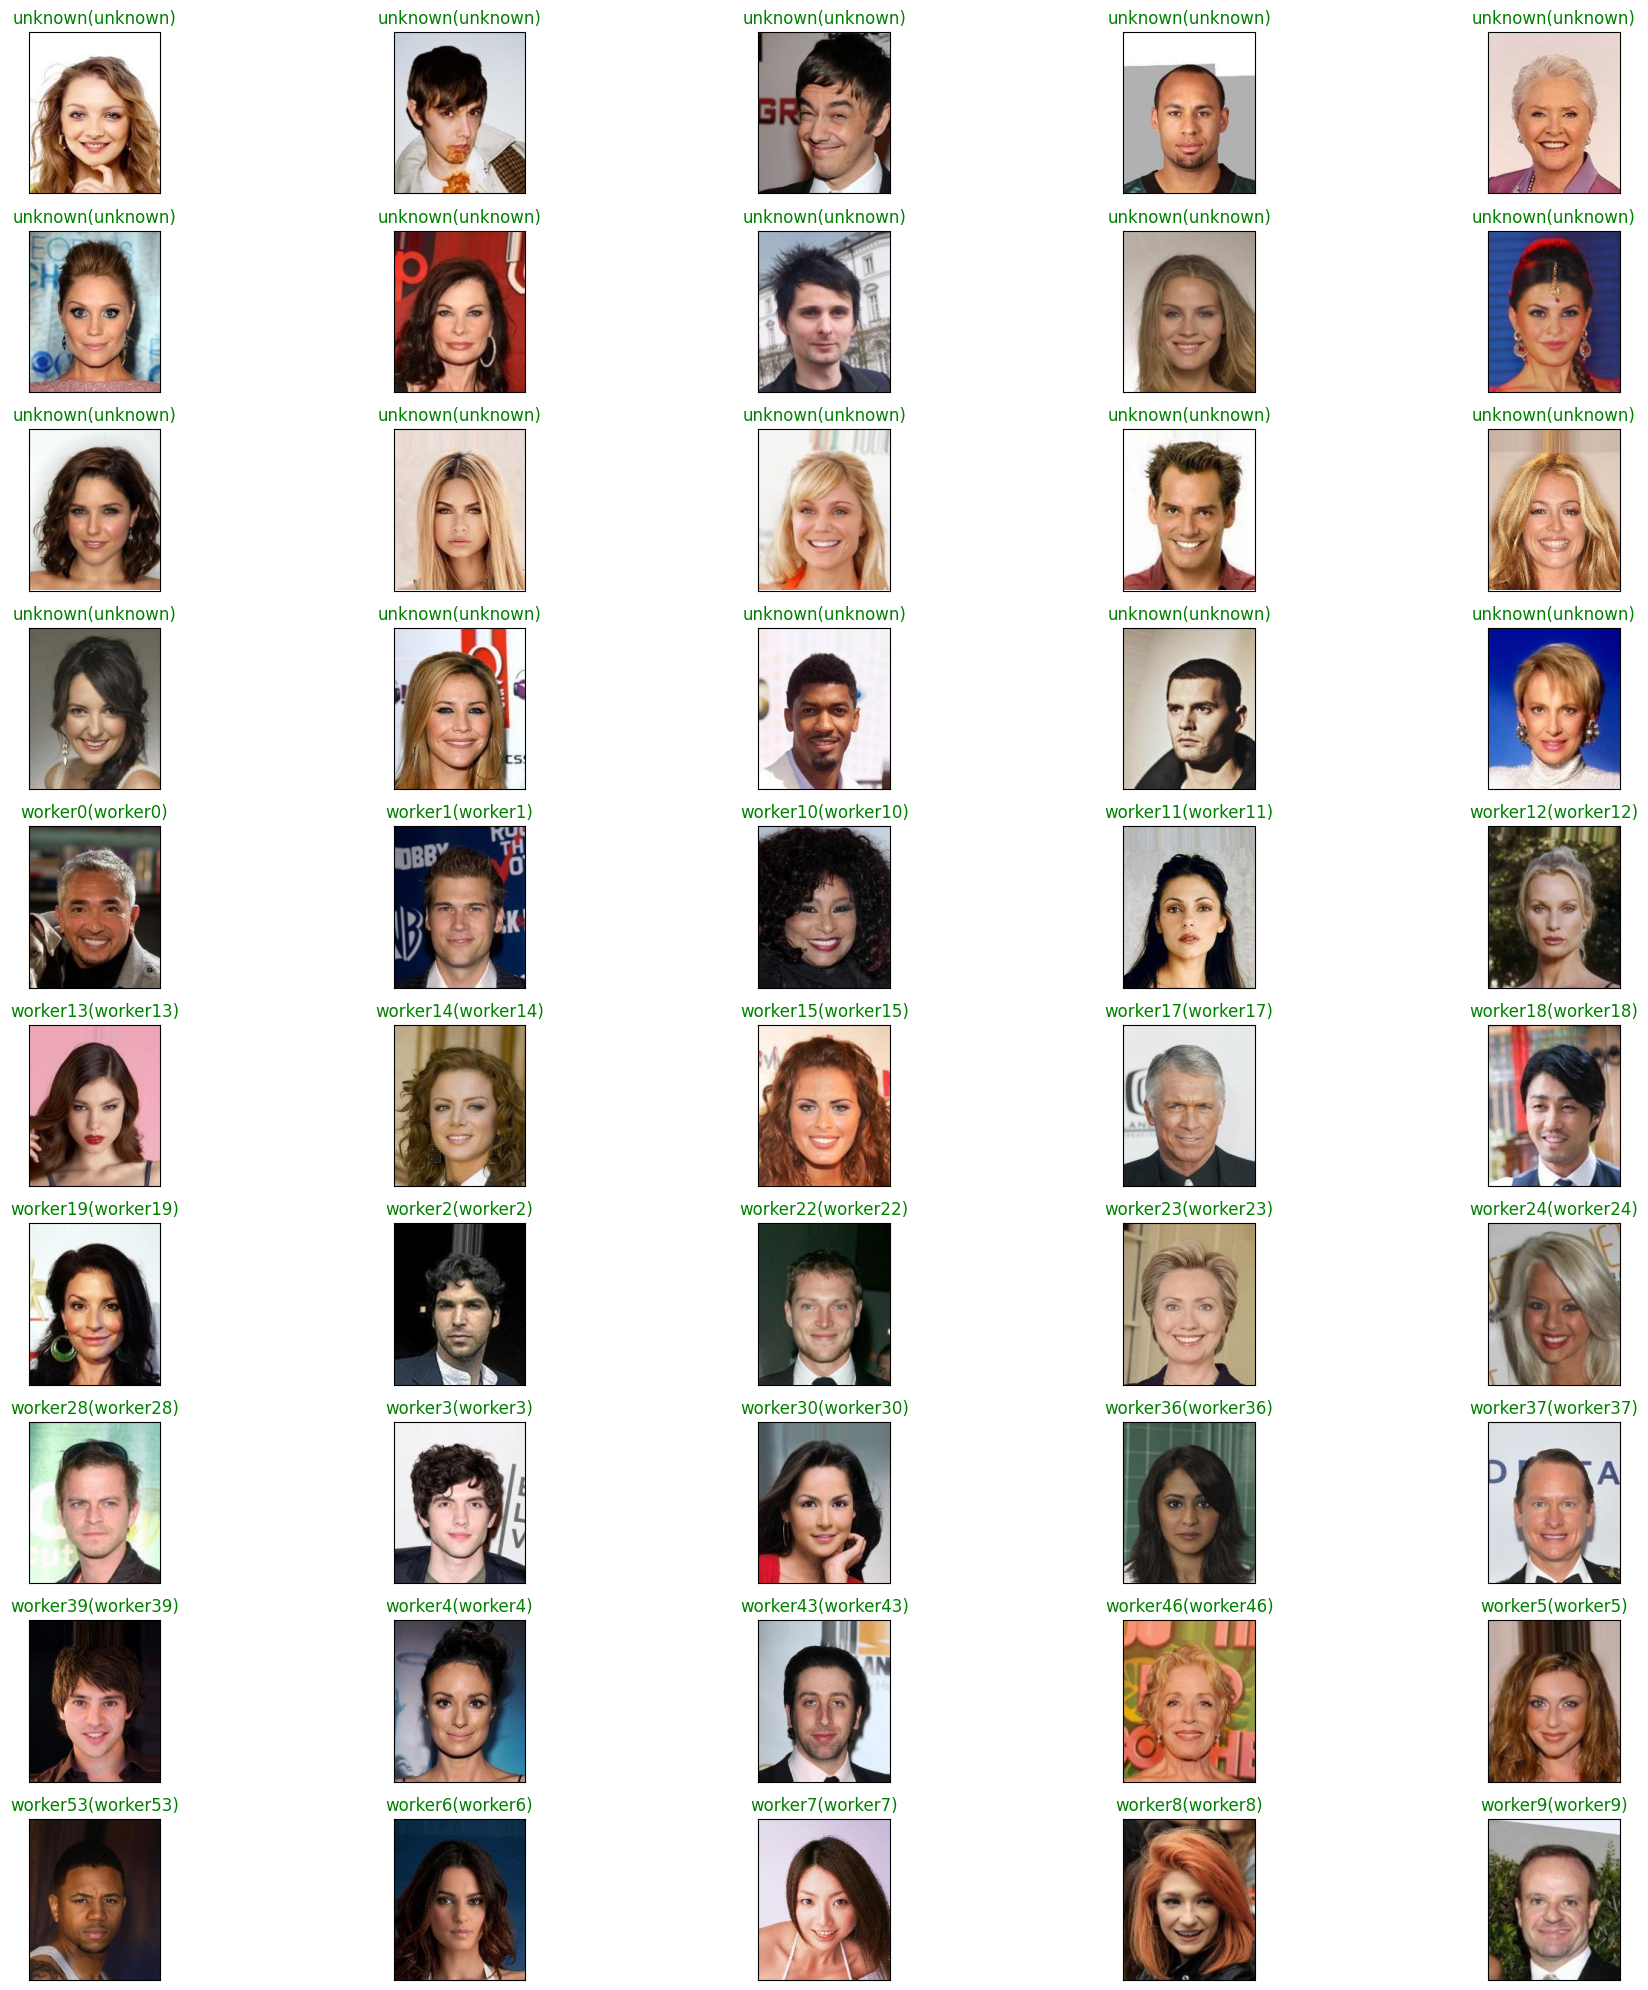

In [7]:
threshold = 11.5

fig, axs = plt.subplots(nrows=len(X_test) // 5, ncols=5, figsize=(20, 20))
i = 0
for x, y in zip(X_test, y_test_raw):
    probas = clf.predict_proba([x])[0]
    pred = probas.argmax()
    proba = probas[pred]
    are_matches = proba * 100 >= threshold
    label = out_encoder.inverse_transform([pred])[0] if are_matches else "unknown"

    title = "{}({})".format(label, y)
    color = "red" if label != y else "green"
    ax = axs[i // 5, i % 5]
    ax.set_title(title, color=color)
    ax.imshow(test_images[i])
    ax.grid(None)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
fig.tight_layout()